In [1]:
# Libraries
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics           import mean_squared_error
from sklearn.model_selection   import cross_val_score
from sklearn.ensemble          import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.utils             import resample

warnings.filterwarnings('ignore')

In [2]:
# local file paths

dir_name = 'regioni'
region_names = np.array(['A', 'B', 'C'])

fp_Xtrain = []
fp_Xval   = []
fp_Xtest  = []
fp_ytrain = []
fp_yval   = []
fp_ytest  = []

for i in range(3):
    fp_Xtrain.append(dir_name + f'/X_train{region_names[i]}.csv')
    fp_Xval  .append(dir_name + f'/X_val{  region_names[i]}.csv')
    fp_Xtest .append(dir_name + f'/X_test{ region_names[i]}.csv')
    fp_ytrain.append(dir_name + f'/y_train{region_names[i]}.csv')
    fp_yval  .append(dir_name + f'/y_val{  region_names[i]}.csv')
    fp_ytest .append(dir_name + f'/y_test{ region_names[i]}.csv')

In [3]:
# Lettura dei dati

X_train = []
X_val   = []
X_test  = []
y_train = []
y_val   = []
y_test  = []

for i in range(3):
    X_train.append(pd.read_csv(fp_Xtrain[i], low_memory=False))
    X_val  .append(pd.read_csv(fp_Xval  [i], low_memory=False))        
    X_test .append(pd.read_csv(fp_Xtest [i], low_memory=False))
    y_train.append(pd.read_csv(fp_ytrain[i], low_memory=False))
    y_val  .append(pd.read_csv(fp_yval  [i], low_memory=False))        
    y_test .append(pd.read_csv(fp_ytest [i], low_memory=False))
    
X_train = np.array(X_train, dtype=object)
X_val   = np.array(X_val,   dtype=object)
X_test  = np.array(X_test,  dtype=object)
y_train = np.array(y_train, dtype=object)
y_val   = np.array(y_val,   dtype=object)
y_test  = np.array(y_test,  dtype=object)

In [4]:
def dimensionality(y=False):
    for i in range(3):
        print(f'X_train{region_names[i]}: {X_train[i].shape}')
        print(f'X_val{region_names[i]}:   {X_val  [i].shape}')
        print(f'X_test{region_names[i]}:  {X_test [i].shape}')
        if y:
            print(f'y_train{region_names[i]}: {y_train[i].shape}')
            print(f'y_val{region_names[i]}:   {y_val  [i].shape}')
            print(f'y_test{region_names[i]}:  {y_test [i].shape}')
            print()

In [5]:
dimensionality(y=True)

X_trainA: (26819, 69)
X_valA:   (9006, 69)
X_testA:  (9085, 69)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 69)
X_valB:   (2658, 69)
X_testB:  (2606, 69)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (64771, 69)
X_valC:   (21908, 69)
X_testC:  (21876, 69)
y_trainC: (64771, 1)
y_valC:   (21908, 1)
y_testC:  (21876, 1)



In [6]:
N_ESTIMATORS = 80
CV = 5
SCORING = 'neg_mean_squared_error'

In [7]:
plt.rcParams.update({'font.size': 35})

In [8]:
def createRF(X, y):
    rf = RandomForestRegressor(n_estimators=N_ESTIMATORS, n_jobs=-1)
    rf.fit(X, y.values.ravel())
    return rf

In [9]:
def barplot(X, rf, reg_name, file_name=''):
    
    print(f'{reg_name} FEATURE IMPORTANCES')
    print(list(X.columns[np.argsort(rf.feature_importances_)[::-1]]))
    print()
    
    fig, ax = plt.subplots(figsize=(len(rf.feature_importances_)/2,10))
    
    ax.tick_params(axis='x', which='major', labelsize=15)
    ax.tick_params(axis='x', which='minor', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=25)
    ax.tick_params(axis='y', which='minor', labelsize=30)
    
    ax.bar(range(0, X.shape[1]), rf.feature_importances_)
    ax.set_title("Feature Importances")
    ax.set_xticks(range(X.shape[1]))
    ax.set_xticklabels(X.columns, rotation=90)
    
    ax.grid()
    
    if file_name != '':
        fig.savefig('images/' + file_name + '_RF_importances.jpg')

In [10]:
def compute_rmse(X, y, bf, debug=False):
    
    rmse  = []

    for f in range(1, len(bf)+1):
        
        if debug:
            print(f)
        
        rf_small = RandomForestRegressor(n_estimators=N_ESTIMATORS, n_jobs=-1)
        cols     = X.columns[bf][:f]
        scores   = cross_val_score(
            rf_small, 
            X.loc[:,cols],
            y.values.ravel(), 
            cv = CV,
            scoring = SCORING,
        )
        rmse += [-scores.mean()]
    
    return rmse

In [11]:
def feature_plot(rmse, reg_name, file_name=''):
    
    min_ = min(rmse)
    best = np.argmin(rmse) + 1
    
    print(f'{reg_name} INCRESAING n-FEATURE PLOT')
    print ("Full score:", rmse[-1])
    print ("Best score:", min_)
    print("Best number of feature: ", best)
    print()

    fig, ax = plt.subplots(figsize=(len(rmse)/2, 10))
    
    ax.tick_params(axis='x', which='major', labelsize=25)
    ax.tick_params(axis='x', which='minor', labelsize=30)
    ax.tick_params(axis='y', which='major', labelsize=30)
    ax.tick_params(axis='y', which='minor', labelsize=35)
    
    ax.plot(range(1, len(rmse)+1), rmse, 'o-', label="RMSE")
    ax.set_title("RMSE on varying features")
    ax.set_xlabel("Number of Best features used")
        
    ax.grid()
    
    if file_name != '':
        fig.savefig('images/' + file_name + '_increasing_rmse.jpg')

In [12]:
def get_selector(X, y):
    rf_small = RandomForestRegressor(n_estimators=N_ESTIMATORS, n_jobs=-1)
    selector = RFECV(
        rf_small, 
        step    = 1,
        cv      = CV,
        scoring = SCORING,
        min_features_to_select = 1,
        n_jobs   = -1
    )
    selector.fit(X, y.values.ravel())
    return selector

In [13]:
def selector_info(sel, X):
    
    print("SELECTOR")
    print("Numero di Feature selezionate: ", sel.n_features_)
    print("Feature: \n", list(X.columns[sel.support_]))
    print()
    print("Ranking delle feature: \n", list(X.columns[np.argsort(sel.ranking_)][:sel.n_features_]))
    print()
    
    return list(X.columns[np.argsort(sel.ranking_)][:sel.n_features_])

In [14]:
def feature_importance(X, y, reg_name, debug=False, file_name=''):
        
    rf = createRF(X, y)
      
    barplot(X, rf, reg_name, file_name=file_name)
    
    best_features = np.argsort(rf.feature_importances_)[::-1]
    
    rmse = compute_rmse(X, y, best_features, debug=debug)
    
    feature_plot(rmse, reg_name, file_name=file_name)

In [15]:
def recursive_selection(X, y):
    
    selector = get_selector(X, y)
    
    selected = selector_info(selector, X)
    
    return selected

In [16]:
feat_selected = []

In [17]:
dimensionality()

X_trainA: (26819, 69)
X_valA:   (9006, 69)
X_testA:  (9085, 69)
X_trainB: (8119, 69)
X_valB:   (2658, 69)
X_testB:  (2606, 69)
X_trainC: (64771, 69)
X_valC:   (21908, 69)
X_testC:  (21876, 69)


In [18]:
#sub_perc = [   1/3,     1,    1/4] # circa 8000
#sub_perc = [     1,     1,    2/5] # A e B uguali, C circa 30000
#sub_perc = [1/1000, 1/100, 1/1000] # circa 100, per testing
sub_perc = [     1,     1,      1] # dataset completo

In [19]:
for i in range(3):
    print(int(len(X_train[i])*sub_perc[i]))

26819
8119
64771


In [20]:
X_train_sub = []
y_train_sub = []

In [21]:
for i in range(3):
    X_sub, y_sub = resample(X_train[i], y_train[i], n_samples = int(sub_perc[i]*len(X_train[i])))
    X_train_sub.append(X_sub)
    y_train_sub.append(y_sub)

In [22]:
def feat_importance(index, debug=False, file_name=''):
    return feature_importance(
        X_train_sub[index],
        y_train_sub[index],
        region_names[index],
        debug=debug,
        file_name=file_name
)

In [23]:
def get_selected(index):
    return recursive_selection(
        X_train_sub[index],
        y_train_sub[index]
)

A FEATURE IMPORTANCES
['tax_ratio', 'latitude', 'tax_prop', 'int_transactiondate', 'structuretaxvaluedollarcnt', 'longitude', 'living_area_prop', 'taxamount', 'lotsizesquarefeet', 'yearbuilt', 'neighborhood_mean_price', 'landtaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'finishedsquarefeet12', 'period_mean_price', 'regionidzip', 'regionidcity', 'roomcnt', 'bedroomcnt', 'rawcensustractandblock', 'bathroomcnt', 'calculatedbathnbr', 'fireplacecnt', 'heatingorsystemtypeid_24.0', 'assessmentyear', 'poolcnt_1.0', 'unitcnt', 'propertycountylandusecode_34', 'heatingorsystemtypeid_6.0', 'propertycountylandusecode_122', 'propertylandusetypeid_261.0', 'propertylandusetypeid_266.0', 'propertycountylandusecode_rare', 'unitcnt_na_flag', 'propertylandusetypeid_260.0', 'propertylandusetypeid_246.0', 'propertylandusetypeid_248.0', 'heatingorsystemtypeid_7.0', 'propertylandusetypeid_247.0', 'heatingorsystemtypeid_18.0', 'heatingorsystemtypeid_13.0', 'heatingorsystemtypeid_1.0'

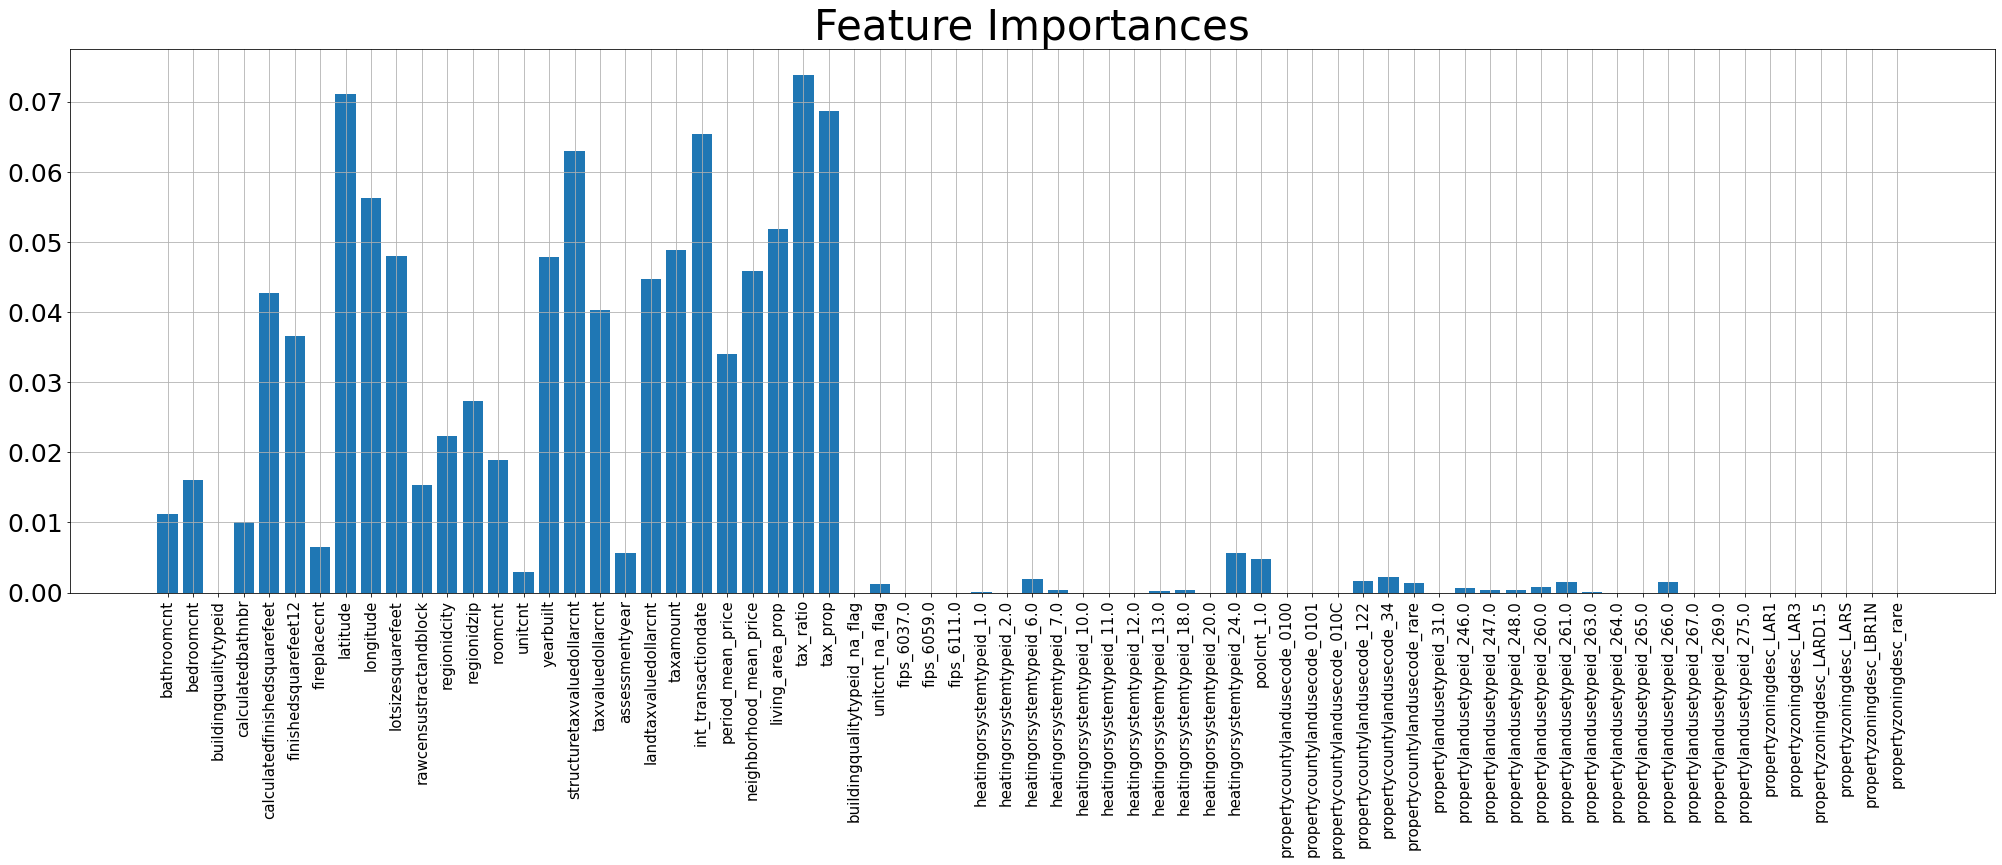

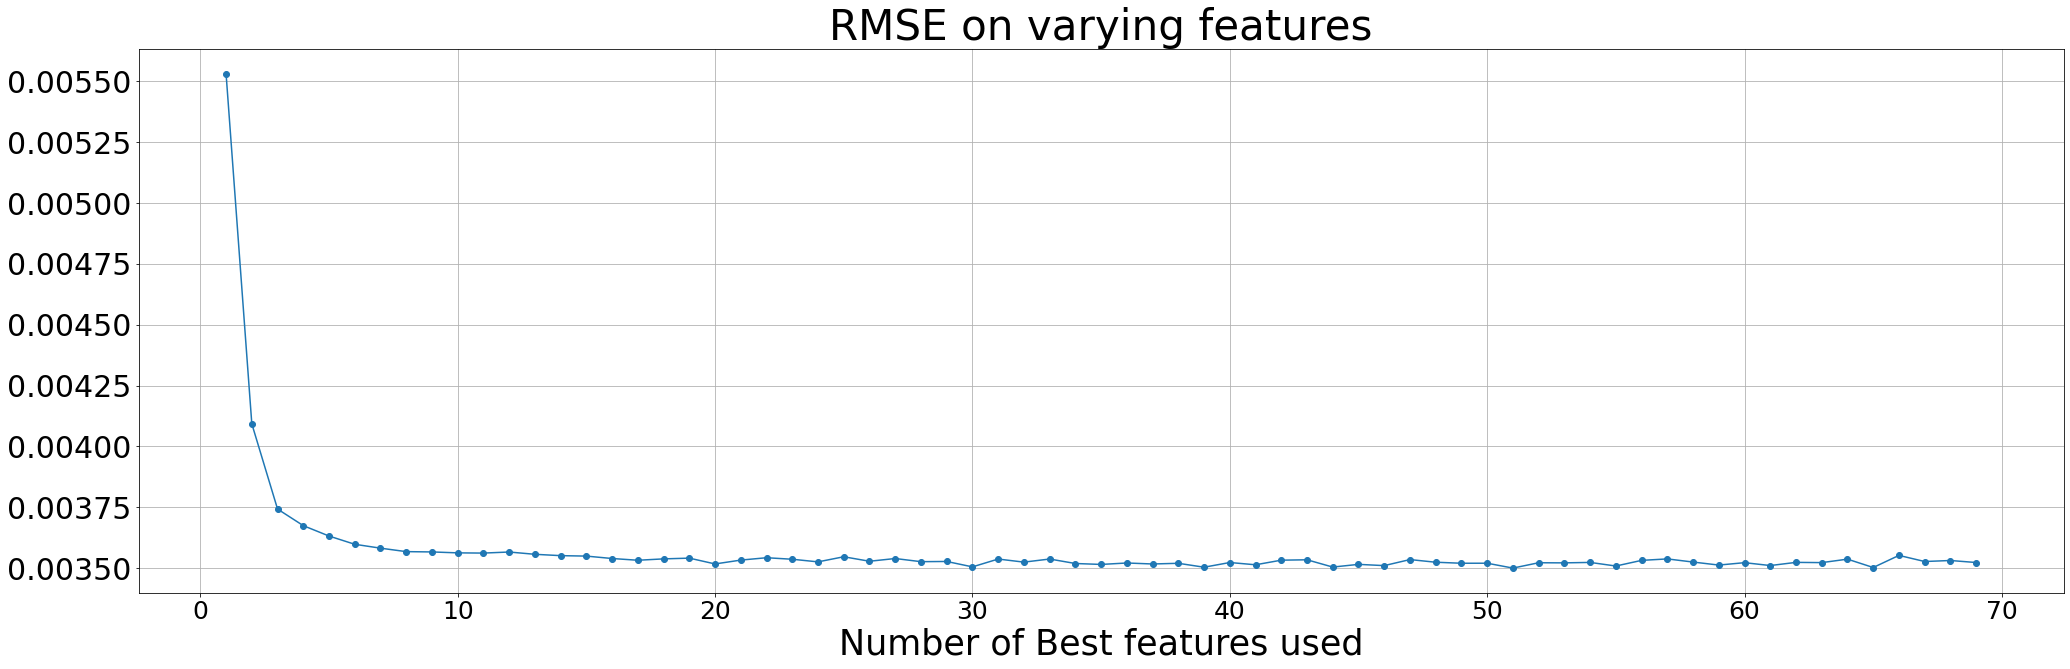

In [24]:
%%time
feat_importance(0, file_name='A')

In [25]:
%%time
feat_selected.append(get_selected(0))

SELECTOR
Numero di Feature selezionate:  41
Feature: 
 ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fireplacecnt', 'latitude', 'longitude', 'lotsizesquarefeet', 'rawcensustractandblock', 'regionidcity', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'int_transactiondate', 'period_mean_price', 'neighborhood_mean_price', 'living_area_prop', 'tax_ratio', 'tax_prop', 'unitcnt_na_flag', 'heatingorsystemtypeid_6.0', 'heatingorsystemtypeid_7.0', 'heatingorsystemtypeid_18.0', 'heatingorsystemtypeid_24.0', 'poolcnt_1.0', 'propertycountylandusecode_122', 'propertycountylandusecode_34', 'propertycountylandusecode_rare', 'propertylandusetypeid_246.0', 'propertylandusetypeid_247.0', 'propertylandusetypeid_248.0', 'propertylandusetypeid_260.0', 'propertylandusetypeid_261.0', 'propertylandusetypeid_266.0']

Ranking delle feature: 

B FEATURE IMPORTANCES
['longitude', 'tax_ratio', 'tax_prop', 'lotsizesquarefeet', 'living_area_prop', 'int_transactiondate', 'structuretaxvaluedollarcnt', 'latitude', 'taxamount', 'landtaxvaluedollarcnt', 'yearbuilt', 'neighborhood_mean_price', 'taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'period_mean_price', 'finishedsquarefeet12', 'regionidzip', 'roomcnt', 'rawcensustractandblock', 'bedroomcnt', 'regionidcity', 'fireplacecnt', 'bathroomcnt', 'calculatedbathnbr', 'propertylandusetypeid_265.0', 'assessmentyear', 'poolcnt_1.0', 'propertylandusetypeid_275.0', 'propertylandusetypeid_266.0', 'propertylandusetypeid_261.0', 'propertylandusetypeid_248.0', 'propertylandusetypeid_247.0', 'unitcnt', 'propertylandusetypeid_246.0', 'propertylandusetypeid_263.0', 'unitcnt_na_flag', 'propertylandusetypeid_269.0', 'buildingqualitytypeid', 'buildingqualitytypeid_na_flag', 'propertyzoningdesc_rare', 'fips_6037.0', 'propertycountylandusecode_0101', 'propertyzoningdesc_LARS', 'propertyzoningdesc_

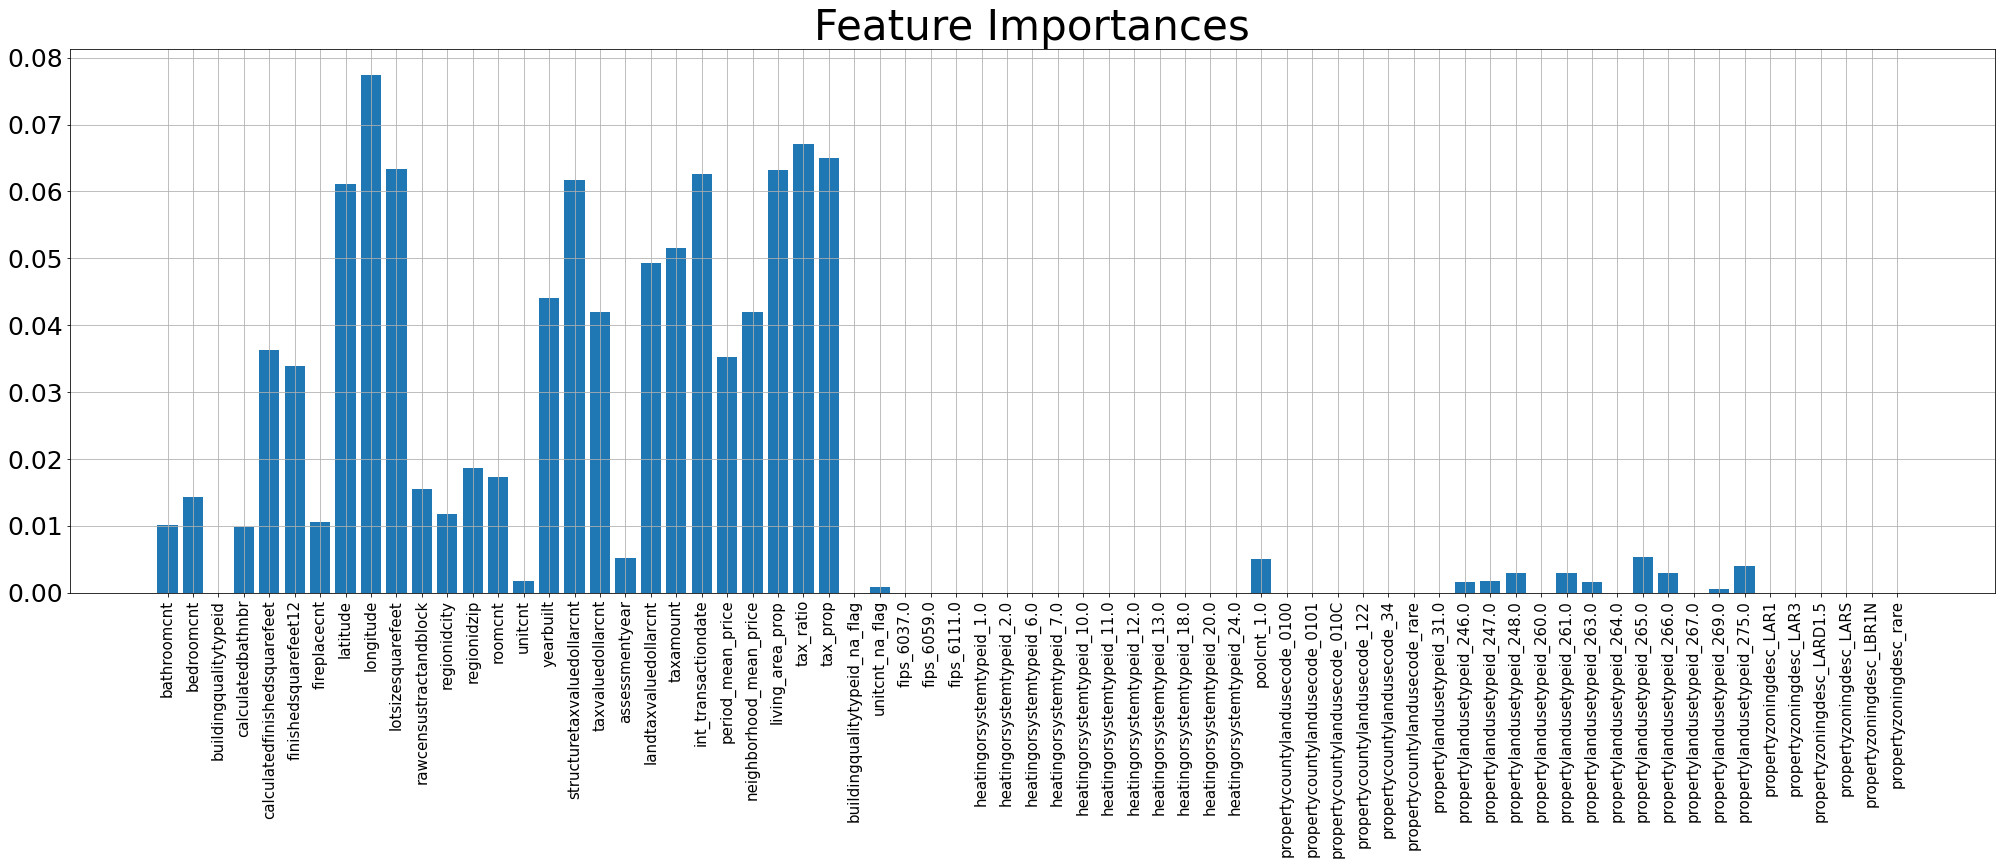

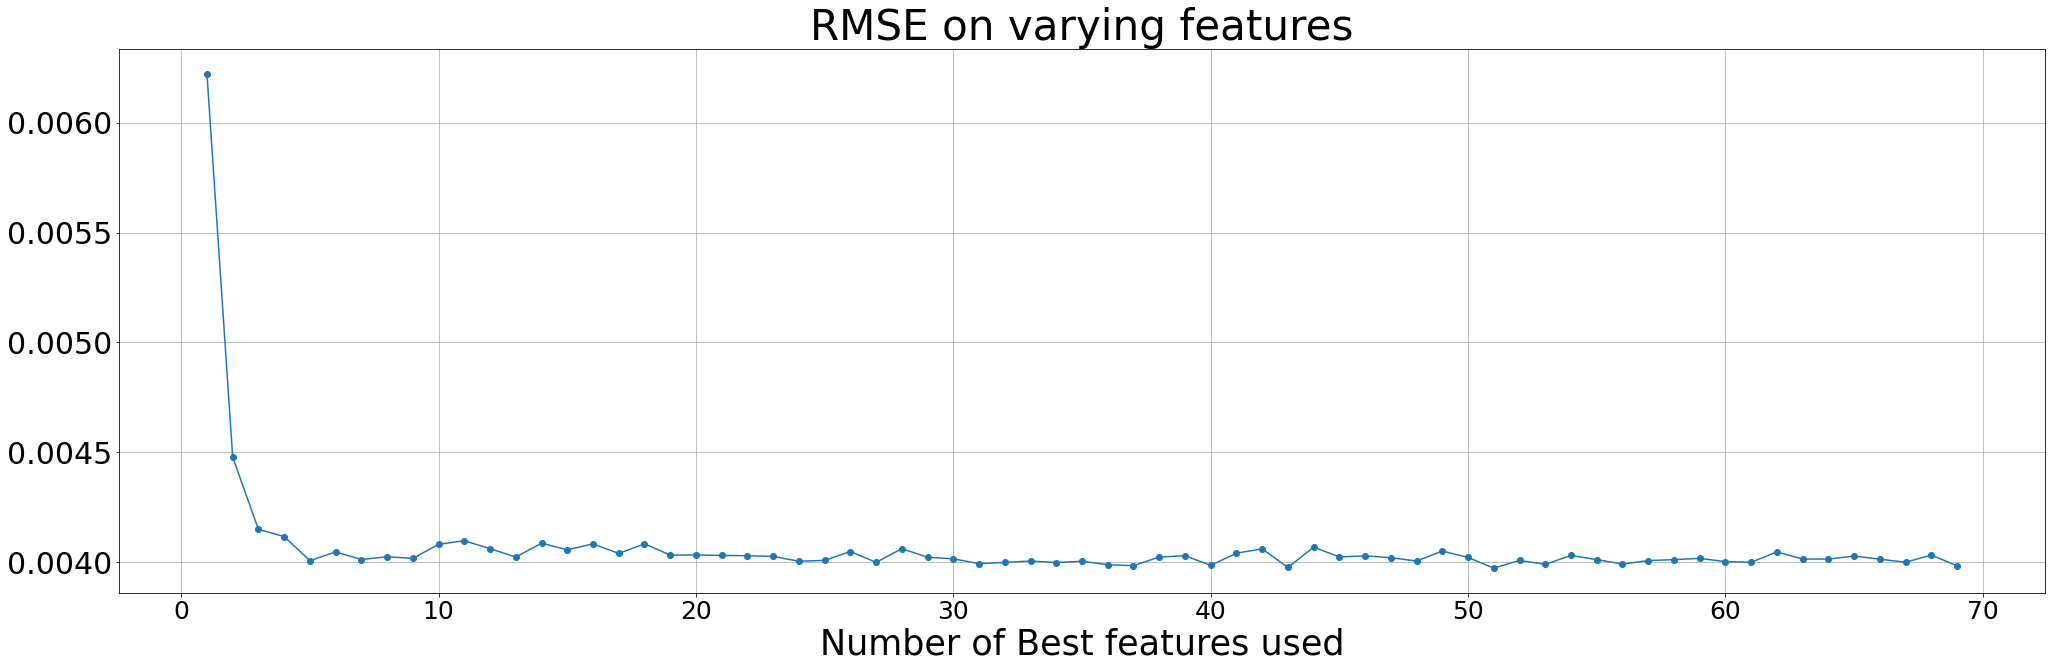

In [26]:
%%time
feat_importance(1, file_name='B')

In [27]:
%%time
feat_selected.append(get_selected(1))

SELECTOR
Numero di Feature selezionate:  34
Feature: 
 ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fireplacecnt', 'latitude', 'longitude', 'lotsizesquarefeet', 'rawcensustractandblock', 'regionidcity', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'int_transactiondate', 'period_mean_price', 'neighborhood_mean_price', 'living_area_prop', 'tax_ratio', 'tax_prop', 'poolcnt_1.0', 'propertylandusetypeid_247.0', 'propertylandusetypeid_248.0', 'propertylandusetypeid_261.0', 'propertylandusetypeid_263.0', 'propertylandusetypeid_265.0', 'propertylandusetypeid_266.0', 'propertylandusetypeid_275.0']

Ranking delle feature: 
 ['bathroomcnt', 'taxamount', 'int_transactiondate', 'period_mean_price', 'neighborhood_mean_price', 'living_area_prop', 'tax_ratio', 'landtaxvaluedollarcnt', 'tax_prop', 'propertylandusetypeid_275.0', 'p

C FEATURE IMPORTANCES
['tax_ratio', 'int_transactiondate', 'longitude', 'tax_prop', 'structuretaxvaluedollarcnt', 'latitude', 'yearbuilt', 'living_area_prop', 'lotsizesquarefeet', 'neighborhood_mean_price', 'taxamount', 'calculatedfinishedsquarefeet', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'finishedsquarefeet12', 'regionidzip', 'rawcensustractandblock', 'period_mean_price', 'regionidcity', 'bedroomcnt', 'buildingqualitytypeid', 'bathroomcnt', 'calculatedbathnbr', 'assessmentyear', 'heatingorsystemtypeid_7.0', 'propertyzoningdesc_LAR1', 'unitcnt', 'heatingorsystemtypeid_2.0', 'poolcnt_1.0', 'propertycountylandusecode_0101', 'propertylandusetypeid_246.0', 'propertycountylandusecode_0100', 'propertyzoningdesc_LARD1.5', 'propertyzoningdesc_rare', 'propertyzoningdesc_LAR3', 'buildingqualitytypeid_na_flag', 'propertycountylandusecode_rare', 'propertyzoningdesc_LBR1N', 'propertyzoningdesc_LARS', 'propertylandusetypeid_261.0', 'unitcnt_na_flag', 'propertylandusetypeid_247.0', 'propertyc

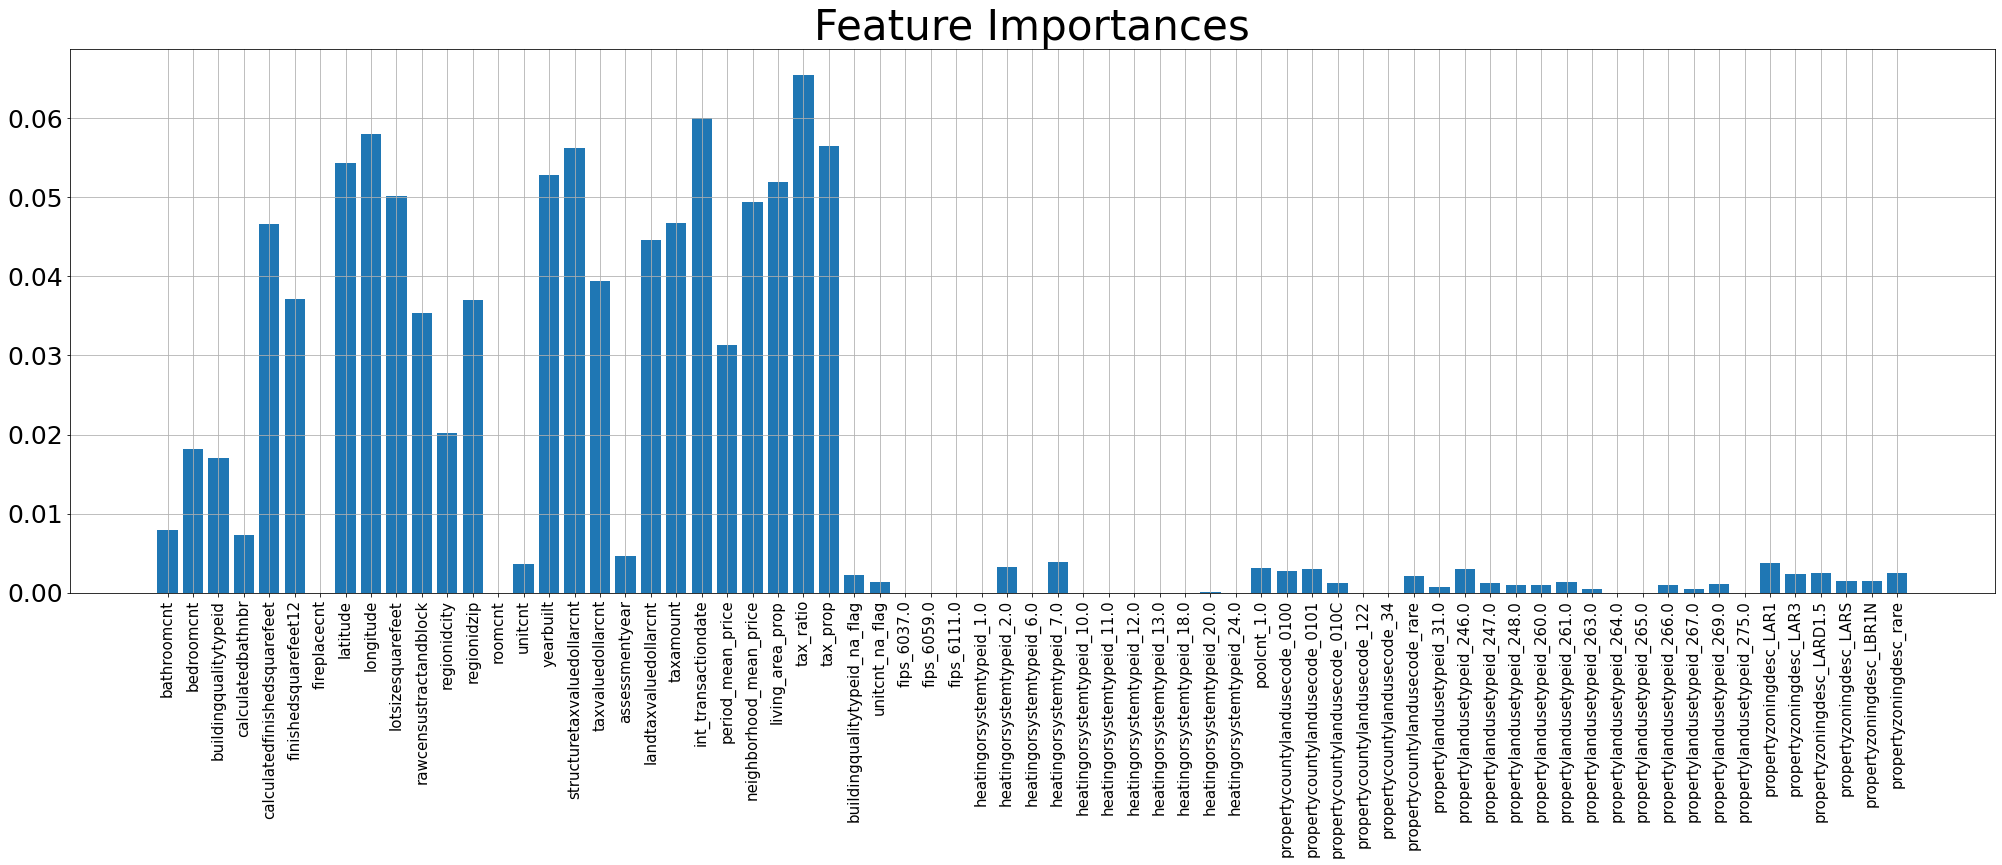

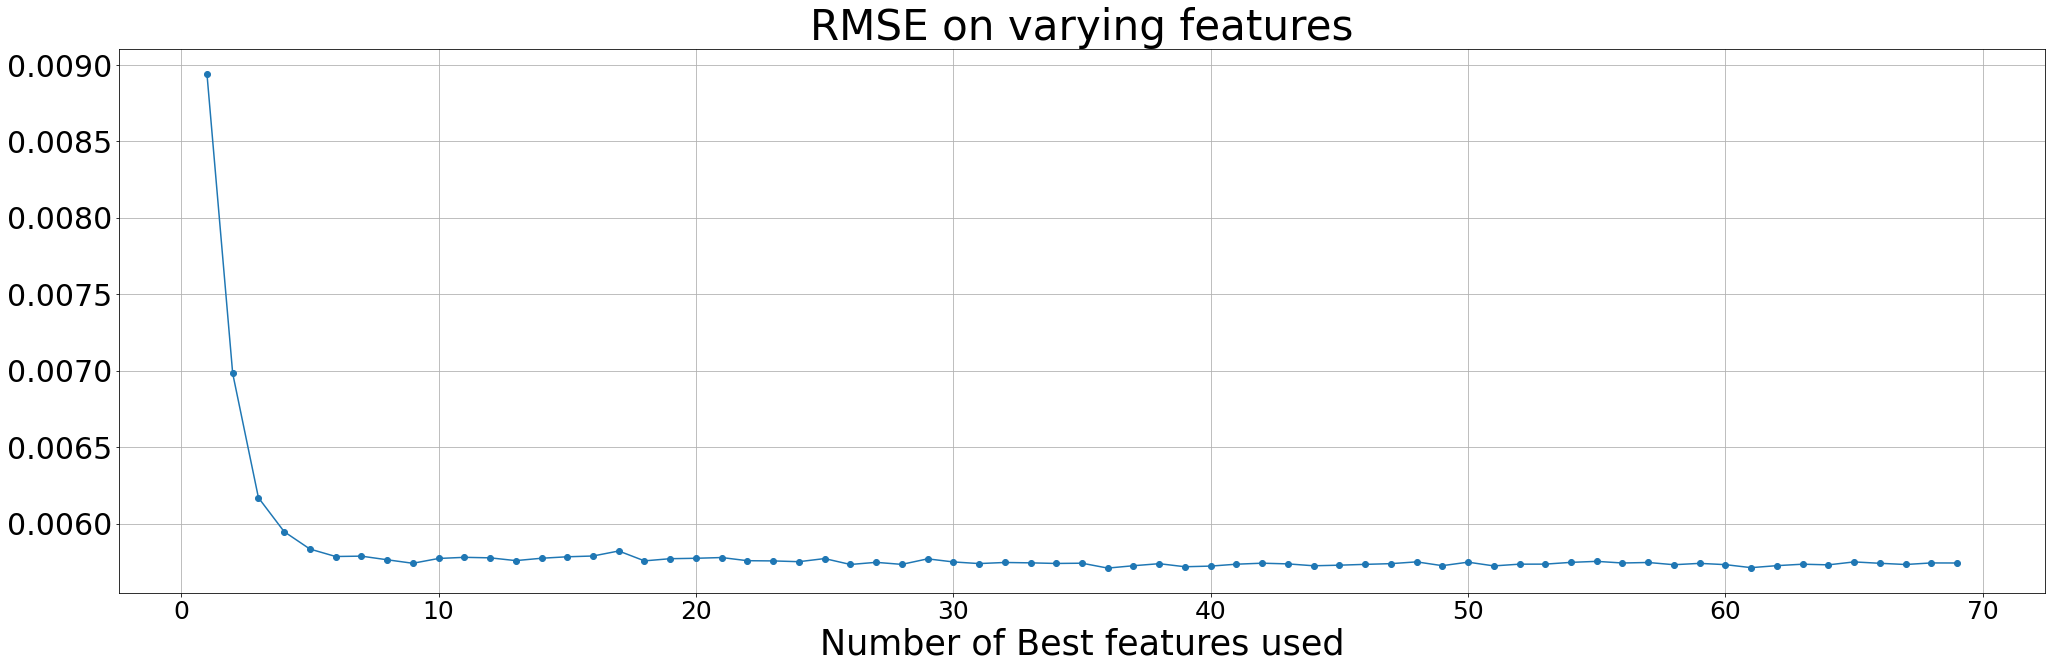

In [28]:
%%time
feat_importance(2, file_name='C')

In [29]:
%%time
feat_selected.append(get_selected(2))

SELECTOR
Numero di Feature selezionate:  48
Feature: 
 ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'latitude', 'longitude', 'lotsizesquarefeet', 'rawcensustractandblock', 'regionidcity', 'regionidzip', 'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'int_transactiondate', 'period_mean_price', 'neighborhood_mean_price', 'living_area_prop', 'tax_ratio', 'tax_prop', 'buildingqualitytypeid_na_flag', 'unitcnt_na_flag', 'heatingorsystemtypeid_2.0', 'heatingorsystemtypeid_7.0', 'poolcnt_1.0', 'propertycountylandusecode_0100', 'propertycountylandusecode_0101', 'propertycountylandusecode_010C', 'propertycountylandusecode_rare', 'propertylandusetypeid_31.0', 'propertylandusetypeid_246.0', 'propertylandusetypeid_247.0', 'propertylandusetypeid_248.0', 'propertylandusetypeid_260.0', 'propertylandusetypeid_261.0', 'propertylanduset

In [30]:
def print_list_info(l):
    print(*l, sep='\n')
    print(f'({len(l)})')

In [31]:
print_list_info(feat_selected[0])

bathroomcnt
neighborhood_mean_price
living_area_prop
tax_ratio
tax_prop
unitcnt_na_flag
heatingorsystemtypeid_7.0
heatingorsystemtypeid_18.0
heatingorsystemtypeid_24.0
period_mean_price
poolcnt_1.0
propertycountylandusecode_34
propertycountylandusecode_rare
propertylandusetypeid_246.0
propertylandusetypeid_247.0
propertylandusetypeid_248.0
propertylandusetypeid_260.0
propertylandusetypeid_261.0
propertylandusetypeid_266.0
propertycountylandusecode_122
int_transactiondate
heatingorsystemtypeid_6.0
landtaxvaluedollarcnt
rawcensustractandblock
regionidcity
lotsizesquarefeet
regionidzip
calculatedbathnbr
roomcnt
longitude
bedroomcnt
latitude
finishedsquarefeet12
unitcnt
calculatedfinishedsquarefeet
yearbuilt
structuretaxvaluedollarcnt
taxvaluedollarcnt
assessmentyear
fireplacecnt
taxamount
(41)


In [32]:
print_list_info(feat_selected[1])

bathroomcnt
taxamount
int_transactiondate
period_mean_price
neighborhood_mean_price
living_area_prop
tax_ratio
landtaxvaluedollarcnt
tax_prop
propertylandusetypeid_275.0
propertylandusetypeid_266.0
propertylandusetypeid_265.0
poolcnt_1.0
propertylandusetypeid_247.0
propertylandusetypeid_248.0
propertylandusetypeid_261.0
assessmentyear
propertylandusetypeid_263.0
structuretaxvaluedollarcnt
bedroomcnt
calculatedbathnbr
calculatedfinishedsquarefeet
taxvaluedollarcnt
fireplacecnt
latitude
longitude
finishedsquarefeet12
unitcnt
rawcensustractandblock
lotsizesquarefeet
yearbuilt
roomcnt
regionidcity
regionidzip
(34)


In [33]:
print_list_info(feat_selected[2])

bathroomcnt
buildingqualitytypeid_na_flag
unitcnt_na_flag
heatingorsystemtypeid_2.0
propertyzoningdesc_LBR1N
heatingorsystemtypeid_7.0
poolcnt_1.0
propertycountylandusecode_0100
propertycountylandusecode_0101
propertycountylandusecode_010C
propertycountylandusecode_rare
tax_prop
propertylandusetypeid_31.0
propertylandusetypeid_247.0
propertylandusetypeid_248.0
propertylandusetypeid_260.0
propertylandusetypeid_261.0
propertylandusetypeid_266.0
propertylandusetypeid_269.0
propertyzoningdesc_LAR1
propertyzoningdesc_LAR3
propertyzoningdesc_LARD1.5
propertyzoningdesc_LARS
propertylandusetypeid_246.0
tax_ratio
propertyzoningdesc_rare
neighborhood_mean_price
unitcnt
yearbuilt
structuretaxvaluedollarcnt
taxvaluedollarcnt
regionidcity
latitude
rawcensustractandblock
lotsizesquarefeet
living_area_prop
finishedsquarefeet12
assessmentyear
landtaxvaluedollarcnt
taxamount
calculatedfinishedsquarefeet
calculatedbathnbr
buildingqualitytypeid
bedroomcnt
int_transactiondate
period_mean_price
longitude
r

In [34]:
to_delete = []
for i in range(3):
    to_del = list(set(X_train[i].columns) - set(feat_selected[i]))
    to_delete.append(to_del)

In [35]:
print_list_info(to_delete[0])

heatingorsystemtypeid_12.0
fips_6037.0
buildingqualitytypeid_na_flag
propertyzoningdesc_LARS
heatingorsystemtypeid_13.0
propertyzoningdesc_rare
heatingorsystemtypeid_2.0
buildingqualitytypeid
propertylandusetypeid_264.0
propertyzoningdesc_LAR3
propertylandusetypeid_265.0
fips_6111.0
heatingorsystemtypeid_20.0
propertyzoningdesc_LARD1.5
fips_6059.0
heatingorsystemtypeid_10.0
propertycountylandusecode_0101
heatingorsystemtypeid_11.0
propertycountylandusecode_0100
propertylandusetypeid_267.0
propertylandusetypeid_269.0
heatingorsystemtypeid_1.0
propertylandusetypeid_275.0
propertyzoningdesc_LBR1N
propertylandusetypeid_263.0
propertyzoningdesc_LAR1
propertycountylandusecode_010C
propertylandusetypeid_31.0
(28)


In [36]:
print_list_info(to_delete[1])

heatingorsystemtypeid_12.0
fips_6037.0
buildingqualitytypeid_na_flag
propertyzoningdesc_LARS
heatingorsystemtypeid_13.0
propertyzoningdesc_rare
heatingorsystemtypeid_2.0
buildingqualitytypeid
propertylandusetypeid_264.0
propertyzoningdesc_LAR3
heatingorsystemtypeid_18.0
fips_6111.0
heatingorsystemtypeid_20.0
propertyzoningdesc_LARD1.5
fips_6059.0
heatingorsystemtypeid_7.0
propertylandusetypeid_246.0
propertylandusetypeid_260.0
heatingorsystemtypeid_10.0
propertycountylandusecode_0101
unitcnt_na_flag
heatingorsystemtypeid_11.0
propertycountylandusecode_0100
propertylandusetypeid_267.0
propertycountylandusecode_rare
propertylandusetypeid_269.0
heatingorsystemtypeid_1.0
heatingorsystemtypeid_24.0
propertyzoningdesc_LBR1N
propertycountylandusecode_34
propertycountylandusecode_122
propertyzoningdesc_LAR1
propertycountylandusecode_010C
propertylandusetypeid_31.0
heatingorsystemtypeid_6.0
(35)


In [37]:
print_list_info(to_delete[2])

heatingorsystemtypeid_12.0
fips_6037.0
fireplacecnt
heatingorsystemtypeid_13.0
propertylandusetypeid_264.0
heatingorsystemtypeid_18.0
propertylandusetypeid_265.0
fips_6111.0
heatingorsystemtypeid_20.0
fips_6059.0
heatingorsystemtypeid_10.0
roomcnt
heatingorsystemtypeid_11.0
propertylandusetypeid_267.0
heatingorsystemtypeid_1.0
propertylandusetypeid_275.0
heatingorsystemtypeid_24.0
propertycountylandusecode_34
propertylandusetypeid_263.0
propertycountylandusecode_122
heatingorsystemtypeid_6.0
(21)


In [38]:
def dim_check():
    correct = True
    dim = len(X_train[0].columns)
    for i in range(3):
        correct &= (len(feat_selected[i]) + len(to_delete[i]) == dim)
    return correct

In [39]:
dim_check()

True

In [40]:
def remove_column(df, col_names):
    df.drop(col_names, axis=1, inplace=True)
    return df

In [41]:
dimensionality(y=True)

X_trainA: (26819, 69)
X_valA:   (9006, 69)
X_testA:  (9085, 69)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 69)
X_valB:   (2658, 69)
X_testB:  (2606, 69)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (64771, 69)
X_valC:   (21908, 69)
X_testC:  (21876, 69)
y_trainC: (64771, 1)
y_valC:   (21908, 1)
y_testC:  (21876, 1)



In [42]:
for i in range(3):
    for X in [X_train[i], X_val[i], X_test[i]]:
        X = remove_column(X, to_delete[i])

In [43]:
dimensionality(y=True)

X_trainA: (26819, 41)
X_valA:   (9006, 41)
X_testA:  (9085, 41)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 34)
X_valB:   (2658, 34)
X_testB:  (2606, 34)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (64771, 48)
X_valC:   (21908, 48)
X_testC:  (21876, 48)
y_trainC: (64771, 1)
y_valC:   (21908, 1)
y_testC:  (21876, 1)



Guardo tra le feature selezionate quelle comuni a tutte e tre le regioni

In [44]:
common = set(X_train[0].columns)

for i in range(1,3):
    common = common.intersection(set(X_train[i].columns))
common = list(common)

print_list_info(common)

propertylandusetypeid_247.0
structuretaxvaluedollarcnt
unitcnt
rawcensustractandblock
longitude
latitude
propertylandusetypeid_248.0
yearbuilt
neighborhood_mean_price
tax_prop
period_mean_price
taxamount
int_transactiondate
propertylandusetypeid_261.0
finishedsquarefeet12
regionidcity
calculatedbathnbr
calculatedfinishedsquarefeet
lotsizesquarefeet
bathroomcnt
poolcnt_1.0
propertylandusetypeid_266.0
assessmentyear
bedroomcnt
tax_ratio
landtaxvaluedollarcnt
regionidzip
living_area_prop
taxvaluedollarcnt
(29)


In [45]:
dir_name = 'selezione'

for i in range(3):
    X_train[i].to_csv( dir_name + f'/X_train{region_names[i]}.csv',  index=False)
    X_val  [i].to_csv( dir_name + f'/X_val{  region_names[i]}.csv',  index=False)
    X_test [i].to_csv( dir_name + f'/X_test{ region_names[i]}.csv',  index=False)
    y_train[i].to_csv( dir_name + f'/y_train{region_names[i]}.csv',  index=False)
    y_val  [i].to_csv( dir_name + f'/y_val{  region_names[i]}.csv',  index=False)
    y_test [i].to_csv( dir_name + f'/y_test{ region_names[i]}.csv',  index=False)    